In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization,Dense,SeparableConv2D,MaxPooling2D,Activation,Flatten,Dropout

In [2]:
INIT_LR = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 50
lr_find = True

classes = ['Non_Fire','Fire']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
images = []
labels = []
for c in classes:
    try:
        for img in os.listdir('drive/MyDrive/Image Dataset/'+c):
            img = cv2.imread('drive/MyDrive/Image Dataset/'+c+'/'+img)
            img = cv2.resize(img,(128,128))
            images.append(img)
            labels.append([0,1][c=='Fire'])
    except:
        pass

images = np.array(images,dtype='float32')/255.

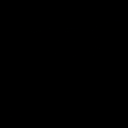

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
ind = np.random.randint(0,len(images))
cv2_imshow(images[ind])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
import tensorflow as tf

labels = np.array(labels)
labels = tf.keras.utils.to_categorical(labels, num_classes=2)

In [6]:
d = {}

classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

d[0] = classWeight[0]
d[1] = classWeight[1]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, shuffle=True, random_state=42)

In [8]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

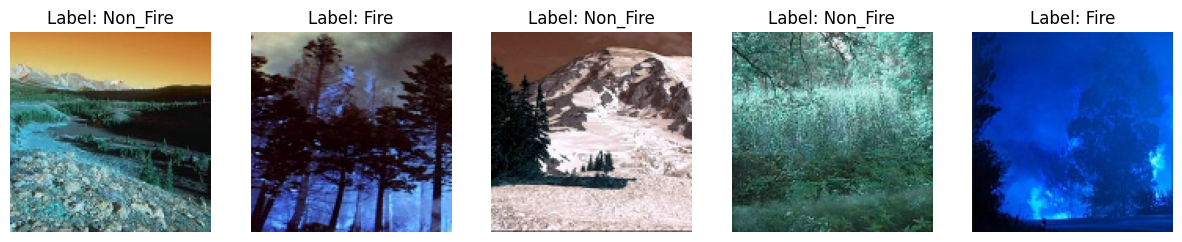

In [13]:
# Display a few random raw images with their labels
def show_random_images(images, labels, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {'Fire' if labels[idx][1] == 1 else 'Non_Fire'}")
        plt.axis('off')
    plt.show()

show_random_images(images, labels)


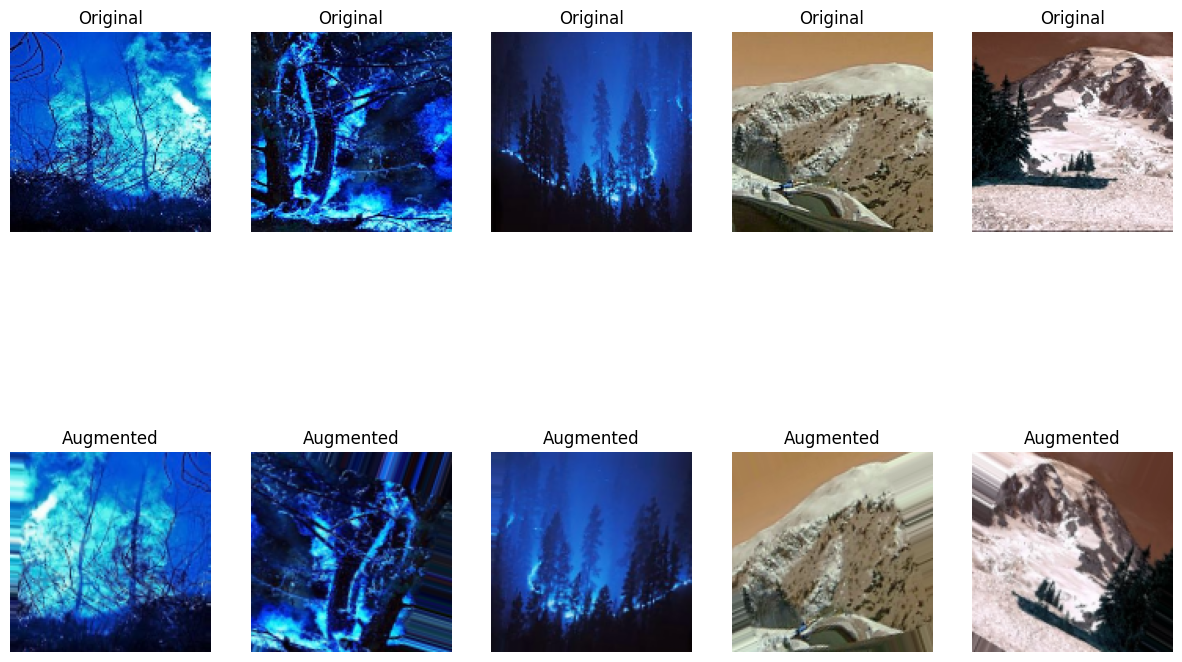

In [14]:
# Display augmented images alongside originals
def show_augmented_images(aug, X_train, num_samples=5):
    original_images = X_train[:num_samples]
    augmented_images = [next(aug.flow(np.expand_dims(img, axis=0), batch_size=1))[0] for img in original_images]

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Original Image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis('off')

        # Augmented Image
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(augmented_images[i])
        plt.title("Augmented")
        plt.axis('off')
    plt.show()

show_augmented_images(aug, X_train)


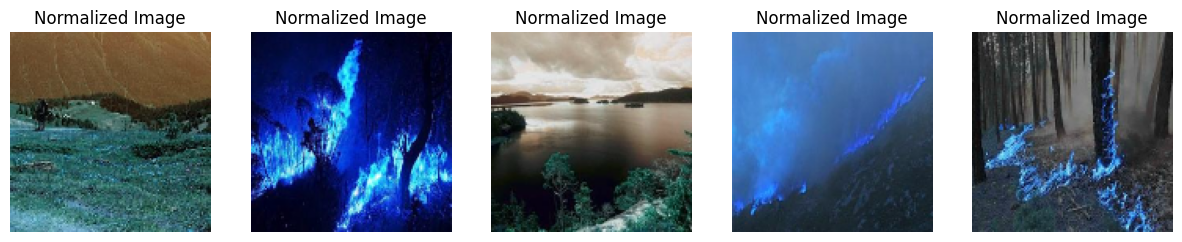

In [15]:
# Visualize normalized images
def show_normalized_images(images, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title("Normalized Image")
        plt.axis('off')
    plt.show()

show_normalized_images(images)


In [25]:
print("Image Matrices (First 3 images):")
for i in range(3):
    print(f"\nImage {i + 1} Matrix:")
    print(images[i])

print("\nLabels (First 3 images):")
print(labels[:3])

Image Matrices (First 3 images):

Image 1 Matrix:
[[[0.8627451  0.5411765  0.22352941]
  [0.8666667  0.54901963 0.23137255]
  [0.87058824 0.5529412  0.23529412]
  ...
  [0.8627451  0.68235296 0.3372549 ]
  [0.87058824 0.6862745  0.34901962]
  [0.87058824 0.6862745  0.34901962]]

 [[0.85882354 0.5372549  0.23137255]
  [0.8627451  0.54509807 0.23921569]
  [0.8627451  0.5529412  0.24313726]
  ...
  [0.8784314  0.69803923 0.3529412 ]
  [0.87058824 0.6862745  0.34901962]
  [0.87058824 0.6862745  0.34901962]]

 [[0.85882354 0.5529412  0.24313726]
  [0.8627451  0.5568628  0.24705882]
  [0.8627451  0.56078434 0.25490198]
  ...
  [0.88235295 0.7176471  0.36862746]
  [0.8745098  0.7058824  0.35686275]
  [0.87058824 0.69803923 0.36078432]]

 ...

 [[0.03529412 0.01568628 0.09803922]
  [0.04705882 0.03529412 0.13725491]
  [0.00392157 0.00784314 0.1254902 ]
  ...
  [0.06666667 0.08627451 0.14117648]
  [0.05882353 0.07843138 0.13725491]
  [0.03921569 0.05882353 0.11764706]]

 [[0.07058824 0.05098039

In [9]:
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16,(7,7),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

opt = SGD(learning_rate=INIT_LR, momentum=0.9,decay=INIT_LR / NUM_EPOCHS)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv2d (SeparableConv2D)   │ (None, 128, 128, 16)        │             211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 64, 64, 32)          │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 32, 32, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 32, 32, 64)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,123,813 (8.10 MB)

 Trainable params: 2,122,949 (8.10 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [16]:
print("Training Model")

H = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=d,
    verbose=1)

print(" serializing network to '{}'...".format('output/model'))
model.save('output/fire_detection.h5')

Training Model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 576ms/step - accuracy: 0.7421 - loss: 0.6412 - val_accuracy: 0.8253 - val_loss: 9.9251
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8438 - loss: 0.3853 - val_accuracy: 0.8674 - val_loss: 9.0972
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.8815 - loss: 0.3087 - val_accuracy: 0.8442 - val_loss: 18.3996
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9688 - loss: 0.1382 - val_accuracy: 0.8400 - val_loss: 19.2027
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9133 - loss: 0.2221 - val_accuracy: 0.8653 - val_loss: 3.0835
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.1970 - val_accuracy: 0.8653 - val_loss: 2.9667
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.9190 - loss: 0.2143 - val_accuracy: 0.8400 - val_loss: 1.7093
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.3928 - val_accuracy: 0.8442 - val_loss: 1.6945
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9243 - loss: 0.1997 - val_accuracy: 0.8779 - val_loss: 0.5505
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.1715 - val_accuracy: 0.8716 - val_loss

 serializing network to 'output/model'...


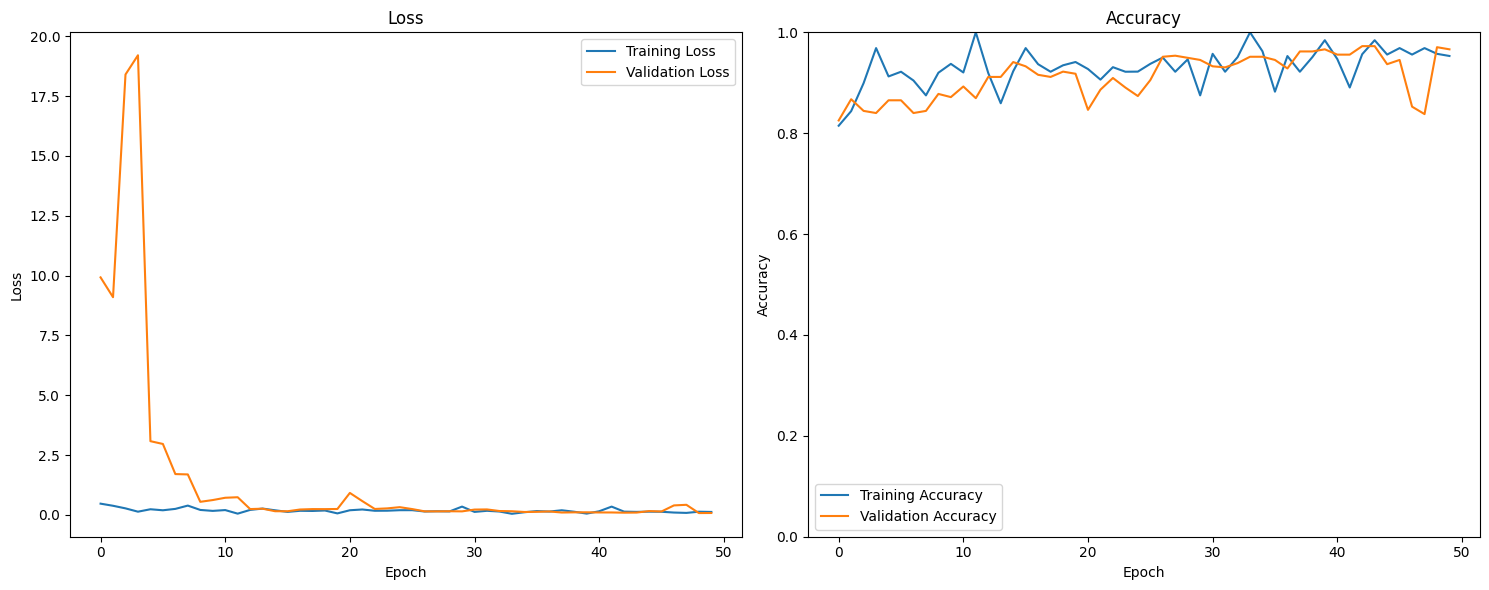

In [19]:
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0, NUM_EPOCHS)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Loss
axes[0].set_title("Loss")
axes[0].plot(N, H.history["loss"], label="Training Loss")
axes[0].plot(N, H.history["val_loss"], label="Validation Loss")
axes[0].set_ylabel("Loss")  # Add y-axis label
axes[0].set_xlabel("Epoch") # Add x-axis label
axes[0].legend()


axes[1].set_title("Accuracy")
axes[1].plot(N, H.history["accuracy"], label="Training Accuracy")
axes[1].plot(N, H.history["val_accuracy"], label="Validation Accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].set_ylim(0, 1)



plt.tight_layout()  # Improves subplot spacing
plt.show()

In [20]:

model = load_model('output/fire_detection.h5')

In [21]:
for i in range(50):
    random_index = np.random.randint(0,len(X_test))
    org_img = X_test[random_index]*255
    img = org_img.copy()
    img = cv2.resize(img,(128,128))
    img = img.astype('float32')/256
    pred = model.predict(np.expand_dims(img,axis=0))[0]
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img,(500,500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 3)
    cv2.imwrite('output/testing/{}.png'.format(i),org_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


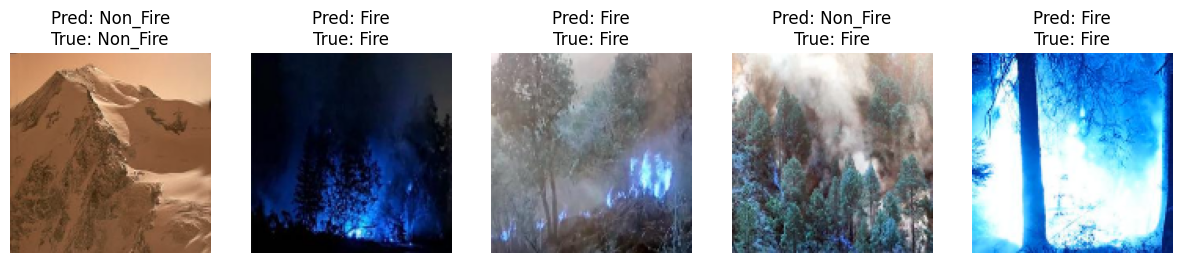

In [22]:
# Display predictions on random test images
def show_predictions(model, X_test, y_test, num_samples=5):
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        predicted_label = 'Fire' if np.argmax(pred) == 1 else 'Non_Fire'
        true_label = 'Fire' if np.argmax(y_test[idx]) == 1 else 'Non_Fire'

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()

show_predictions(model, X_test, y_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


<Figure size 800x600 with 0 Axes>

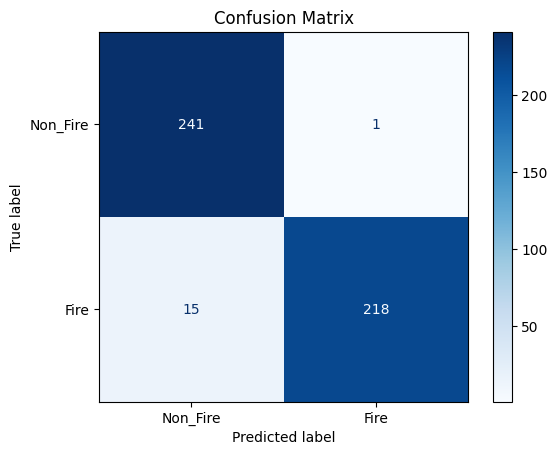

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [24]:

print(f"Total dataset size: {len(images)}")
print(f"Training dataset size: {len(X_train)}")
print(f"Testing dataset size: {len(X_test)}")


Total dataset size: 1900
Training dataset size: 1425
Testing dataset size: 475


In [26]:
from sklearn.metrics import classification_report


y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=classes)
print("Classification Report:\n")
print(report)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:

              precision    recall  f1-score   support

    Non_Fire       0.94      1.00      0.97       242
        Fire       1.00      0.94      0.96       233

    accuracy                           0.97       475
   macro avg       0.97      0.97      0.97       475
weighted avg       0.97      0.97      0.97       475



In [29]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.63%
